# RecSys for News

The MIND dataset contains 15M impressions generated by 1M users over 160k news articles.

In order to build a Recommender System, we would be first cleaning and pre-processing the data, then developing simple features to finally train and evaluate (DLRM).

## Import libraries and create directories

In [ ]:
# Install packages required for this notebook
!pip install tqdm
!apt install wget unzip

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1).
wget is already the newest version (1.20.3-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


In [ ]:
import time, glob, shutil, sys, os, pickle, json
from tqdm import tqdm
import boto3
import os
import shutil

import cupy as cp          
import cudf                
import rmm                 

import numpy as np

from nvtabular.ops import Operator
import nvtabular as nvt
from nvtabular.utils import device_mem_size

import dask
import dask_cudf
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
from dask.distributed import wait
from dask.utils import parse_bytes
from dask.delayed import delayed

In [ ]:
# Initialize the S3 client
s3_client = boto3.client('s3')

# S3 bucket name and folder prefix
bucket_name = 'rjgyrocs5w7'
train_prefix = 'MINDlarge_train/'
valid_prefix = 'MINDlarge_dev/'
file_names = ['behaviors.tsv', 'news.tsv', 'entity_embedding.vec', 'relation_embedding.vec']

# Define root directory where all artifacts would be saved
BASE_DIR = os.environ.get("BASE_DIR", "./basedir")

# Define worker/output directories
dask_workdir = os.path.join(BASE_DIR, "workdir")

# Directory to store the raw downloaded dataset
data_input_path = os.path.join(BASE_DIR, "dataset")
data_path_train = os.path.join(data_input_path, "train")
data_path_valid = os.path.join(data_input_path, "valid")

# Directory to store pre-processed dataset
data_output_path = os.path.join(BASE_DIR, "processed_nvt")
output_train_path = os.path.join(data_output_path, "train")
output_valid_path = os.path.join(data_output_path, "valid")

# Directory to model configuration and
config_output_path = os.path.join(BASE_DIR, "configs")
weights_path = os.path.join(BASE_DIR, "weights")

def create_clean_directory(path):
    if os.path.isdir(path):
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

# Creating and cleaning our worker/output directories
try:
    os.makedirs(BASE_DIR, exist_ok=True)

    create_clean_directory(dask_workdir)
    create_clean_directory(data_input_path)
    create_clean_directory(data_path_train)
    create_clean_directory(data_path_valid)
    create_clean_directory(data_output_path)
    create_clean_directory(output_train_path)
    create_clean_directory(output_valid_path)
    create_clean_directory(config_output_path)
    create_clean_directory(weights_path)

except OSError as e:
    print(f"Creation of the directories failed: {e}")
else:
    print("Successfully created the directories")

# Function to download a file from S3 to the specified local path
def download_file_from_s3(bucket, s3_key, local_path):
    """Download a file from S3 to the specified local path."""
    try:
        s3_client.download_file(bucket, s3_key, local_path)
        print(f"Downloaded {s3_key} to {local_path}")
    except Exception as e:
        print(f"Failed to download {s3_key}: {e}")

# Download files for the training set
for file_name in file_names:
    train_s3_key = train_prefix + file_name
    train_local_path = os.path.join(data_path_train, file_name)
    download_file_from_s3(bucket_name, train_s3_key, train_local_path)

# Download files for the validation set
for file_name in file_names:
    valid_s3_key = valid_prefix + file_name
    valid_local_path = os.path.join(data_path_valid, file_name)
    download_file_from_s3(bucket_name, valid_s3_key, valid_local_path)

Successfully created the directories
Downloaded MINDlarge_train/behaviors.tsv to ./basedir/dataset/train/behaviors.tsv
Downloaded MINDlarge_train/news.tsv to ./basedir/dataset/train/news.tsv
Downloaded MINDlarge_train/entity_embedding.vec to ./basedir/dataset/train/entity_embedding.vec
Downloaded MINDlarge_train/relation_embedding.vec to ./basedir/dataset/train/relation_embedding.vec
Downloaded MINDlarge_dev/behaviors.tsv to ./basedir/dataset/valid/behaviors.tsv
Downloaded MINDlarge_dev/news.tsv to ./basedir/dataset/valid/news.tsv
Downloaded MINDlarge_dev/entity_embedding.vec to ./basedir/dataset/valid/entity_embedding.vec
Downloaded MINDlarge_dev/relation_embedding.vec to ./basedir/dataset/valid/relation_embedding.vec


## Setup dask for distributed processing

In [ ]:
# Check the GPUs that are available to this notebook
!nvidia-smi

Thu Nov 14 01:57:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.12              Driver Version: 550.90.12      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:08:00.0 Off |                  Off |
| N/A   27C    P0             42W /  400W |       4MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Initialize Dask GPU Cluster

In [ ]:
NUM_GPUS = [0] # add GPU IDs available on the server

dashboard_port = "8787"

protocol = "tcp"             # "tcp" or "ucx"
visible_devices = ",".join([str(n) for n in NUM_GPUS])  
device_spill_frac = 0.9      

# Get device memory capacity
capacity = device_mem_size(kind="total")

cluster = None              
if cluster is None:
    cluster = LocalCUDACluster(
        protocol = protocol,
        n_workers=len(visible_devices.split(",")),
        CUDA_VISIBLE_DEVICES = visible_devices,
        device_memory_limit = capacity * device_spill_frac,
        local_directory=dask_workdir,
        dashboard_address=":" + dashboard_port,
    )

# Create the distributed client
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:39867 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 232.21 GB


In [ ]:
# Initialize RMM pool on ALL workers
def _rmm_pool():
    rmm.reinitialize(
        pool_allocator=True,
        initial_pool_size=None,
    )

client.run(_rmm_pool)

{'tcp://127.0.0.1:36983': None}

## Explore MIND dataset





### Dataset format

Each set of this data (train/valid/test) contains the following 4 files:

1. behaviors.tsv - The click history and impression logs of users
2. news.tsv - Details of news articles mapped with the news ID
3. entity_embedding.vec - The embeddings of entities in news extracted from knowledge graph
4. relation_embedding.vec - The embeddings of relations between entities extracted from knowledge graph

Let's take a look at both these TSV files and understand how we can utilise them for our Recommendation System. 

### Behaviors data

In [ ]:
behaviors_train = cudf.read_csv(os.path.join(data_path_train , 'behaviors.tsv'),
                                header=None,
                                sep='\t',)
behaviors_train.head()

,0,1,2,3,4
0,1,U87243,11/10/2019 11:30:54 AM,N8668 N39081 N65259 N79529 N73408 N43615 N2937...,N78206-0 N26368-0 N7578-0 N58592-0 N19858-0 N5...
1,2,U598644,11/12/2019 1:45:29 PM,N56056 N8726 N70353 N67998 N83823 N111108 N107...,N47996-0 N82719-0 N117066-0 N8491-0 N123784-0 ...
2,3,U532401,11/13/2019 11:23:03 AM,N128643 N87446 N122948 N9375 N82348 N129412 N5...,N103852-0 N53474-0 N127836-0 N47925-1
3,4,U593596,11/12/2019 12:24:09 PM,N31043 N39592 N4104 N8223 N114581 N92747 N1207...,N38902-0 N76434-0 N71593-0 N100073-0 N108736-0...
4,5,U239687,11/14/2019 8:03:01 PM,N65250 N122359 N71723 N53796 N41663 N41484 N11...,N76209-0 N48841-0 N67937-0 N62235-0 N6307-0 N3...


In [ ]:
behaviors_columns = ['impression_id', 'uid', 'time', 'history', 'impressions']

In [ ]:
behaviors_train = cudf.read_csv(os.path.join(data_path_train , 'behaviors.tsv'),
                          header=None,
                          names=behaviors_columns,
                    sep='\t',)
behaviors_train.head()

,impression_id,uid,time,history,impressions
0,1,U87243,11/10/2019 11:30:54 AM,N8668 N39081 N65259 N79529 N73408 N43615 N2937...,N78206-0 N26368-0 N7578-0 N58592-0 N19858-0 N5...
1,2,U598644,11/12/2019 1:45:29 PM,N56056 N8726 N70353 N67998 N83823 N111108 N107...,N47996-0 N82719-0 N117066-0 N8491-0 N123784-0 ...
2,3,U532401,11/13/2019 11:23:03 AM,N128643 N87446 N122948 N9375 N82348 N129412 N5...,N103852-0 N53474-0 N127836-0 N47925-1
3,4,U593596,11/12/2019 12:24:09 PM,N31043 N39592 N4104 N8223 N114581 N92747 N1207...,N38902-0 N76434-0 N71593-0 N100073-0 N108736-0...
4,5,U239687,11/14/2019 8:03:01 PM,N65250 N122359 N71723 N53796 N41663 N41484 N11...,N76209-0 N48841-0 N67937-0 N62235-0 N6307-0 N3...


In [ ]:
behaviors_valid = cudf.read_csv(os.path.join(data_path_valid , 'behaviors.tsv'),
                          header=None,
                          names=behaviors_columns,
                    sep='\t',)
behaviors_valid.head()

,impression_id,uid,time,history,impressions
0,1,U134050,11/15/2019 8:55:22 AM,N12246 N128820 N119226 N4065 N67770 N33446 N10...,N91737-0 N30206-0 N54368-0 N117802-0 N18190-0 ...
1,2,U254959,11/15/2019 11:42:35 AM,N34011 N9375 N67397 N7936 N118985 N109453 N103...,N119999-0 N24958-0 N104054-0 N33901-0 N9250-0 ...
2,3,U499841,11/15/2019 9:08:21 AM,N63858 N26834 N6379 N85484 N15229 N65119 N1047...,N18190-0 N89764-0 N91737-0 N54368-0 N49978-1 N...
3,4,U107107,11/15/2019 5:50:31 AM,N12959 N8085 N18389 N3758 N9740 N90543 N129790...,N122944-1 N18190-0 N55801-0 N59297-0 N128045-0...
4,5,U492344,11/15/2019 5:02:25 AM,N109183 N48453 N85005 N45706 N98923 N46069 N35...,N64785-0 N82503-0 N32993-0 N122944-0 N29160-0 ...


### News data

In [ ]:
news_train = cudf.read_csv(os.path.join(data_path_train , 'news.tsv'),
                          header=None,
                          sep='\t',)
news_train.head()

,0,1,2,3,4,5,6,7
0,N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N45436,news,newsscienceandtechnology,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on l...,https://assets.msn.com/labs/mind/AABmf2I.html,"[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ...","[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ..."
2,N23144,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
3,N86255,health,medical,Dispose of unwanted prescription drugs during ...,<NA>,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
4,N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."


In [ ]:
news_columns = ['did', 'cat', 'sub_cat', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities']

In [ ]:
news_train = cudf.read_csv(os.path.join(data_path_train , 'news.tsv'),
                          header=None,
                          names=news_columns,
                    sep='\t',)
news_train.head()

,did,cat,sub_cat,title,abstract,url,title_entities,abstract_entities
0,N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N45436,news,newsscienceandtechnology,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on l...,https://assets.msn.com/labs/mind/AABmf2I.html,"[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ...","[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ..."
2,N23144,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
3,N86255,health,medical,Dispose of unwanted prescription drugs during ...,<NA>,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
4,N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."


In [ ]:
news_valid = cudf.read_csv(os.path.join(data_path_valid , 'news.tsv'),
                          header=None,
                          names=news_columns,
                    sep='\t',)
news_valid.head()

,did,cat,sub_cat,title,abstract,url,title_entities,abstract_entities
0,N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N23144,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N86255,health,medical,Dispose of unwanted prescription drugs during ...,<NA>,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
3,N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
4,N75236,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."


## Preprocessing

### Filter out columns

In [ ]:
news_train = news_train.drop(['title', 'abstract', 'url', 'title_entities', 'abstract_entities'],axis = 1)
news_valid = news_valid.drop(['title', 'abstract', 'url', 'title_entities', 'abstract_entities'],axis = 1)

# Merging news train/valid dataset to have a single view of news and their attributes
news = cudf.concat([news_train,news_valid]).drop_duplicates().reset_index().drop(['index'],axis=1)

# Freeing up memory by nulling the variables
news_train = None
news_valid = None

news.head()

,did,cat,sub_cat
0,N1,sports,football_nfl
1,N100,finance,markets
2,N1000,weather,weathertopstories
3,N10000,entertainment,celebrity
4,N100000,sports,football_nfl


In [ ]:
# Encoding user id from both train and validation dataframe
user_index = {}

temp = cudf.concat([behaviors_train['uid'],behaviors_valid['uid']]).unique().to_pandas()
for i in tqdm(range(len(temp)),total = len(temp)):
    user_index[temp[i]] = i + 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750434/750434 [00:02<00:00, 319049.36it/s]


In [ ]:
# Replacing uid in the dataset with their respective indexes

behaviors_train['uid'] = behaviors_train['uid'].replace([i for i in user_index],[str(user_index[i]) for i in user_index]).astype('int')
behaviors_valid['uid'] = behaviors_valid['uid'].replace([i for i in user_index],[str(user_index[i]) for i in user_index]).astype('int')

# Freeing up memory by nulling variables
user_index = None

In [ ]:
# Encoding news id from the combined news dataframe
news_index = {}

for n,data in tqdm(news.to_pandas().iterrows(),total = len(news)):
    news_index[data['did']] = n + 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104151/104151 [00:06<00:00, 16238.31it/s]


In [ ]:
# Encoding new's category and subcategories

cat = {}
subcat = {}

temp = news['cat'].unique()
for i in tqdm(range(len(temp)),total = len(temp)):
    cat[temp[i]] = i + 1

temp = news['sub_cat'].unique()
for i in tqdm(range(len(temp)),total = len(temp)):
    subcat[temp[i]] = i + 1

# Replacing did, cat and sub_cate with their respective indexes in the news dataframe
news = news.replace({'did': [i for i in news_index], 'cat': [i for i in cat], 'sub_cat': [i for i in subcat]},{'did': [str(news_index[i]) for i in news_index], 'cat': [str(cat[i]) for i in cat], 'sub_cat': [str(subcat[i]) for i in subcat]}).astype('int')
news = news.set_index('did').to_pandas().T.to_dict()

# Freeing up memory by nulling variables
temp = None
cat = None
subcat = None

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 377.16it/s]


Unrolling history into multiple columns. Only using 10 most recent news articles from history

As an example, consider the below row in behaviours dataframe

|impression_id | uid | time | history | impressions |
| :-: | :-: | :-: |:-: |:-: |
| 1 | U64099 | 11/19/2019 11:37:45 AM |	N121133 N104200 N43255 N55860 N128965 N38014 | N78206-0 N26368-1 N7578-1 N58592-0 N19858-0 |

We have to convert one history column with many news id to multiple history columns with single news id. 

| hist_0 | hist_1 | hist_2 | hist_3 | hist_4 | hist_5 |
| :-: | :-: | :-: | :-: | :-: | :-: |
|	N121133 | N104200 | N43255 | N55860 | N128965 | N38014 |

Finally, we will add the news category and subcategory for these news ids. The row after these transformations would look like this:

|impression_id | uid | time | hist_cat_0 | hist_cat_1 | hist_cat_2 | ... | hist_subcat_3 | hist_subcat_4 | hist_subcat_5 | impressions |
| :-: | :-: | :-: |:-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| 1 | U64099 | 11/19/2019 11:37:45 AM |	sports | finance | entertainment | ... | markets | celebrity | football_nfl | N78206-0 N26368-1 N7578-1 N58592-0 N19858-0 |

In [ ]:
max_hist = 10

In [ ]:
hist = cudf.DataFrame() 

# Splitting the long string of history into several columns
hist[['hist_'+str(i) for i in range(max_hist)]] = behaviors_train.history.str.rsplit(n=max_hist,expand=True).fillna(0)[[i for i in range(1,max_hist+1)]]

# Replacing string news id in history with respective indexes
hist = hist.replace([i for i in news_index],[str(news_index[i]) for i in news_index]).astype('int')

# Appending news category corresponding to these newly created history columns
behaviors_train[['hist_cat_'+str(i) for i in range(max_hist)]] = hist.replace([int(i) for i in news],[int(news[i]['cat']) for i in news])

# Appending news sub-category corresponding to these newly created history columns
behaviors_train[['hist_subcat_'+str(i) for i in range(max_hist)]] = hist.replace([int(i) for i in news],[int(news[i]['sub_cat']) for i in news])

# Creating a column for the length of history 
behaviors_train['hist_count'] = behaviors_train.history.str.count(" ")+1

# Dropping the long string history column
behaviors_train = behaviors_train.drop(['history'],axis=1)

# Freeing up memory by nulling variables
hist = None

In [ ]:
# Repeating the same for validation set
hist = cudf.DataFrame()

hist[['hist_'+str(i) for i in range(max_hist)]] = behaviors_valid.history.str.rsplit(n=max_hist,expand=True).fillna(0)[[i for i in range(1,max_hist+1)]]

hist = hist.replace([i for i in news_index],[str(news_index[i]) for i in news_index]).astype('int')

behaviors_valid[['hist_cat_'+str(i) for i in range(max_hist)]] = hist.replace([int(i) for i in news],[int(news[i]['cat']) for i in news])

behaviors_valid[['hist_subcat_'+str(i) for i in range(max_hist)]] = hist.replace([int(i) for i in news],[int(news[i]['sub_cat']) for i in news])

behaviors_valid['hist_count'] = behaviors_valid.history.str.count(" ")+1

behaviors_valid = behaviors_valid.drop(['history'],axis=1)

hist = None

Unroll items in impression column

As an example, consider the below expanded history column row from the behaviours dataframe:

|impression_id | uid | time | hist_cat_0 | hist_cat_1 | hist_cat_2 | ... | hist_subcat_3 | hist_subcat_4 | hist_subcat_5 | impressions |
| :-: | :-: | :-: |:-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| 1 | U64099 | 11/19/2019 11:37:45 AM |	sports | finance | entertainment | ... | markets | celebrity | football_nfl | N78206-0 N26368-1 N7578-1 N58592-0 N19858-0 |

The impression column contains the positive and negetive samples as a long string.

After unrolling one row of impressions into multiple rows, the resulting dataframe would look like this:

|impression_id | uid | time | hist_cat_0 | hist_cat_1 | hist_cat_2 | ... | hist_subcat_3 | hist_subcat_4 | hist_subcat_5 | impressions | label |
| :-: | :-: | :-: |:-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| 1 | U64099 | 11/19/2019 11:37:45 AM |	sports | finance | entertainment | ... | markets | celebrity | football_nfl | N78206 | 0 |
| 1 | U64099 | 11/19/2019 11:37:45 AM |	sports | finance | entertainment | ... | markets | celebrity | football_nfl | N26368 | 1 |
| 1 | U64099 | 11/19/2019 11:37:45 AM |	sports | finance | entertainment | ... | markets | celebrity | football_nfl | N7578 | 1 |
| 1 | U64099 | 11/19/2019 11:37:45 AM |	sports | finance | entertainment | ... | markets | celebrity | football_nfl | N58592 | 0 |
| 1 | U64099 | 11/19/2019 11:37:45 AM |	sports | finance | entertainment | ... | markets | celebrity | football_nfl | N19858 | 0 |

Note that all the 5 generated rows have the same impression_id, uid, time and history data columns.

In [ ]:
max_impr = 100

In [ ]:
# Converting impressions column to dictionary of lists
# For train dataset
impr_train = behaviors_train.set_index('impression_id').impressions.to_pandas().str.split()
impr_train = impr_train.to_dict()
behaviors_train = behaviors_train.drop(['impressions'],axis=1)

# For validation dataset
impr_valid = behaviors_valid.set_index('impression_id').impressions.to_pandas().str.split()
impr_valid = impr_valid.to_dict()
behaviors_valid = behaviors_valid.drop(['impressions'],axis=1)

In [ ]:
np_ratio = -1 # ratio of neg-to-pos samples

In [ ]:
# For train set

imp_id = []
imp_list = []
imp_label = []
for i in tqdm(impr_train,total = len(impr_train)):
    imp, label = np.transpose([[news_index[imp.split('-')[0]],imp.split('-')[1]] for imp in impr_train[i]])
    pos = (label == '1').sum()
    neg = 0
    for j in range(min(len(imp),max_impr)):
        if label[j] == '0' and np_ratio > -1:
            if neg <= pos*np_ratio :
                imp_id.append(i)
                imp_list.append(imp[j])
                imp_label.append(label[j])
                neg+=1
        else:
            imp_id.append(i)
            imp_list.append(imp[j])
            imp_label.append(label[j])

impr_train = None 

# Creating a new gdf with impression id, news id and its label
impressions_train = cudf.DataFrame({'imp_id': imp_id,'impr': imp_list,'label': imp_label})

# Appending news category corresponding to above impression news in the above created DataFrame
impressions_train['impr_cat'] = impressions_train['impr'].replace([int(i) for i in news],[int(news[i]['cat']) for i in news])

# Appending news sub-category corresponding to above impression news in above created DataFrame
impressions_train['impr_subcat'] = impressions_train['impr'].replace([int(i) for i in news],[int(news[i]['sub_cat']) for i in news])

# Droping impr columns as news data is added for it.
impressions_train = impressions_train.drop(['impr'],axis=1)

impressions_train.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2232748/2232748 [04:15<00:00, 8748.54it/s]


,imp_id,label,impr_cat,impr_subcat
0,1,0,84769,84769
1,1,0,38819,38819
2,1,0,82639,82639
3,1,0,67404,67404
4,1,0,32985,32985


In [ ]:
# For validation set

imp_id = []
imp_list = []
imp_label = []
for i in tqdm(impr_valid,total = len(impr_valid)):
    imp, label = np.transpose([[news_index[imp.split('-')[0]],imp.split('-')[1]] for imp in impr_valid[i]])
    pos = (label == '1').sum()
    neg = 0
    for j in range(min(len(imp),max_impr)):
        if label[j] == '0' and np_ratio > -1:
            if neg <= pos*np_ratio :
                imp_id.append(i)
                imp_list.append(imp[j])
                imp_label.append(label[j])
                neg+=1
        else:
            imp_id.append(i)
            imp_list.append(imp[j])
            imp_label.append(label[j])

impr_valid = None 

impressions_valid = cudf.DataFrame({'imp_id': imp_id,'impr': imp_list,'label': imp_label})
impressions_valid['impr_cat'] = impressions_valid['impr'].replace([int(i) for i in news],[int(news[i]['cat']) for i in news])
impressions_valid['impr_subcat'] = impressions_valid['impr'].replace([int(i) for i in news],[int(news[i]['sub_cat']) for i in news])
impressions_valid = impressions_valid.drop(['impr'],axis=1)
impressions_valid.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 376471/376471 [00:41<00:00, 9112.52it/s]


,imp_id,label,impr_cat,impr_subcat
0,1,0,96774,96774
1,1,0,42250,42250
2,1,0,63649,63649
3,1,0,15784,15784
4,1,0,31476,31476


In [ ]:
# Freeing up memory by nulling variables
imp_id = None
imp_list = None
imp_label = None

Merge behaviors and news dataset

In [ ]:
# For training set
rmm.reinitialize(managed_memory=True)

final_data = impressions_train.merge(behaviors_train,left_on = ['imp_id'],right_on = ['impression_id']).drop(['imp_id'],axis=1)
final_data = cudf.concat([final_data.drop(['time'],axis=1).astype('int'),final_data['time']],axis=1)
final_data.to_parquet(os.path.join(data_input_path, 'train.parquet'), compression = None)

# Freeing up memory by nulling variables
final_data=None
impressions_train = None
behaviors_train = None

#client.run(_rmm_pool)

In [ ]:
# For validation set

final_data = impressions_valid.merge(behaviors_valid,left_on = ['imp_id'],right_on = ['impression_id']).drop(['imp_id'],axis=1)
final_data = cudf.concat([final_data.drop(['time'],axis=1).astype('int'),final_data['time']],axis=1)
final_data.to_parquet(os.path.join(data_input_path, 'valid.parquet'),compression = None)

# Freeing up memory by nulling variables
final_data=None
impressions_valid = None
behaviors_valid = None

`train.parquet` and `test.parquet` are the pre-process datasets that we can use for feature engineering

create timebased features

In [ ]:
# Declaring features of train set that we created

cat_features = [
 'hist_cat_0',
 'hist_subcat_0',
 'hist_cat_1',
 'hist_subcat_1',
 'hist_cat_2',
 'hist_subcat_2',
 'hist_cat_3',
 'hist_subcat_3',
 'hist_cat_4',
 'hist_subcat_4',
 'hist_cat_5',
 'hist_subcat_5',
 'hist_cat_6',
 'hist_subcat_6',
 'hist_cat_7',
 'hist_subcat_7',
 'hist_cat_8',
 'hist_subcat_8',
 'hist_cat_9',
 'hist_subcat_9',
 'impr_cat',
 'impr_subcat',
 'impression_id',
 'uid']

cont_features = ['hist_count']

labels = ['label']

In [ ]:
# Creating time based features by extracting the relevant elements using cuDF

datetime = nvt.ColumnGroup(['time']) >> (lambda col: cudf.to_datetime(col,format="%m/%d/%Y %I:%M:%S %p"))

hour = datetime >> (lambda col: col.dt.hour) >> nvt.ops.Rename(postfix = '_hour')
minute = datetime >> (lambda col: col.dt.minute) >> nvt.ops.Rename(postfix = '_minute')
seconds = datetime >> (lambda col: col.dt.second) >> nvt.ops.Rename(postfix = '_second')

weekday = datetime >> (lambda col: col.dt.weekday) >> nvt.ops.Rename(postfix = '_wd')
day = datetime >> (lambda col: cudf.to_datetime(col, unit='s').dt.day) >> nvt.ops.Rename(postfix = '_day')

week = day >> (lambda col: (col/7).floor().astype('int')) >> nvt.ops.Rename(postfix = '_week')

In [ ]:
cat_features = cat_features + hour + minute + seconds + weekday + day + week + datetime >> nvt.ops.Categorify(out_path = data_output_path)
cont_features = cont_features >> nvt.ops.FillMissing() >> nvt.ops.NormalizeMinMax()
labels = ['label']

Visualize the complete workflow pipeline.

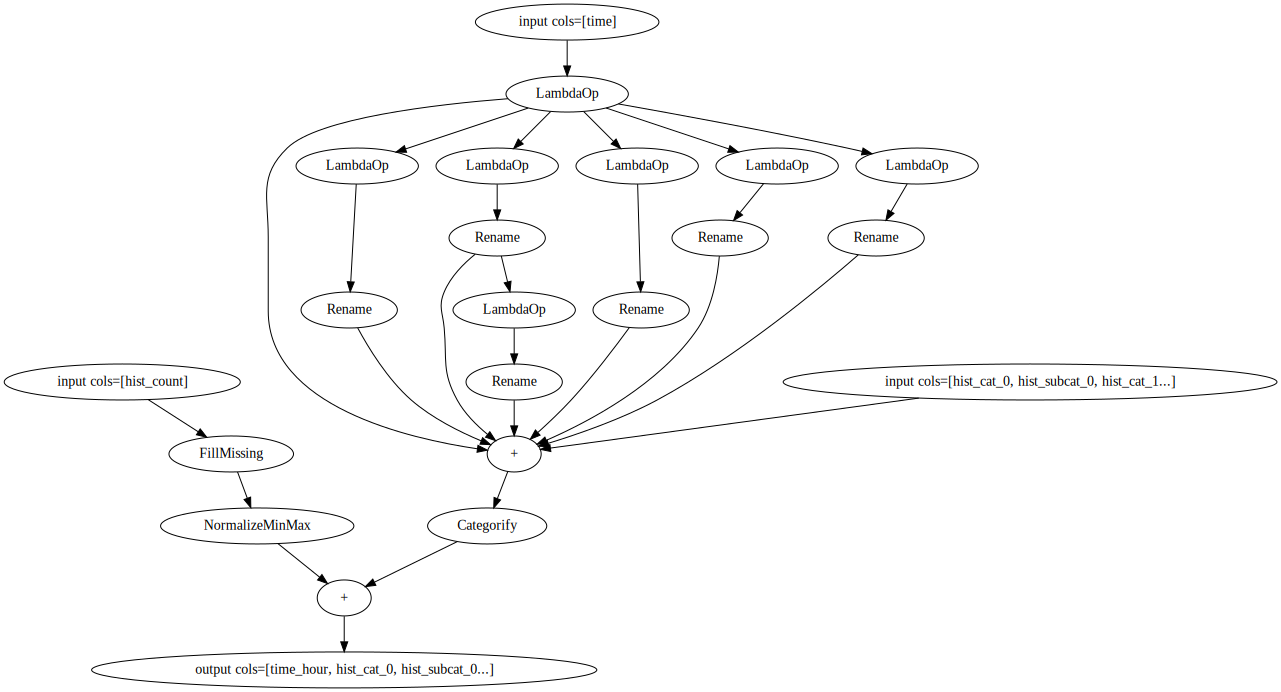

In [ ]:
output = cat_features + cont_features
output.graph

In [ ]:
proc = nvt.Workflow(cat_features + cont_features + labels[0])

In [ ]:
# Initialize a nvt.Dataset from parquet file that was created in step 4.

data_train = nvt.Dataset(os.path.join(data_input_path, "train.parquet"), engine="parquet",part_size="256MB")
data_valid = nvt.Dataset(os.path.join(data_input_path, "valid.parquet"), engine="parquet",part_size="256MB")

In [ ]:
dict_dtypes={}

for col in cat_features.columns:
    dict_dtypes[col] = np.int64

for col in cont_features.columns:
    dict_dtypes[col] = np.float32

for col in labels:
    dict_dtypes[col] = np.float32

Let's fit the workflow on the training set to record the statistics.

In [ ]:
%%time
proc.fit(data_train)

CPU times: user 1min 59s, sys: 19.6 s, total: 2min 18s
Wall time: 2min 20s


Next, we apply the transformation to the dataset and persist it to disk as parquet.

In [ ]:
%%time

# For training set
proc.transform(data_train).to_parquet(output_path= output_train_path,
                                shuffle=nvt.io.Shuffle.PER_PARTITION,
                                dtypes=dict_dtypes,
                                out_files_per_proc=10,
                                cats = cat_features.columns,
                                conts = cont_features.columns,
                                labels = labels)

CPU times: user 3min 20s, sys: 53.8 s, total: 4min 14s
Wall time: 4min 11s


In [ ]:
%%time

# For validation set
proc.transform(data_valid).to_parquet(output_path= output_valid_path,
                                shuffle=nvt.io.Shuffle.PER_PARTITION,
                                dtypes=dict_dtypes,
                                out_files_per_proc=10,
                                cats = cat_features.columns,
                                conts = cont_features.columns,
                                labels = labels)

CPU times: user 32.7 s, sys: 8.82 s, total: 41.6 s
Wall time: 41.1 s


Let's load the NVTabular processed parquet files and look at our first NVTabular pre-processed dataset.

In [ ]:
df = dask_cudf.read_parquet(os.path.join(output_train_path, '*.parquet'))
df.head()

,time_hour,hist_cat_0,hist_subcat_0,hist_cat_1,hist_subcat_1,hist_cat_2,hist_subcat_2,hist_cat_3,hist_subcat_3,hist_cat_4,...,impression_id,uid,time_minute,time_second,time_wd,time_day,time_day_week,time,hist_count,label
0,4,8,128,3,49,3,56,3,49,15,...,1790,69501,26,9,2,4,1,47170,0.007491,0.0
1,4,5,187,6,137,12,149,6,97,5,...,3185,555888,43,48,2,4,1,48229,0.019975,0.0
2,12,12,172,12,176,3,154,12,173,14,...,65,627819,9,1,2,4,1,50042,0.009988,0.0
3,8,12,165,17,232,13,159,12,165,4,...,2921,180321,5,1,2,4,1,49602,0.061174,0.0
4,11,12,172,15,219,14,87,12,171,13,...,274,418873,1,6,2,4,1,49867,0.011236,0.0


In [ ]:
with open(os.path.join(output_train_path, '_metadata.json'),'r') as f:
    metadata = json.load(f)

metadata

{'file_stats': [{'file_name': '0.1e8e8a37f0a64d889d311abee99c8b56.parquet',
   'num_rows': 7717331},
  {'file_name': '1.17ded3b36f454311968ae752870370d1.parquet',
   'num_rows': 7720295},
  {'file_name': '2.5bb8b372ece24812aeee5bcfd8cd7e2b.parquet',
   'num_rows': 7716484},
  {'file_name': '3.3f02b54c086b492cb52d84a81c11a6ac.parquet',
   'num_rows': 7717967},
  {'file_name': '4.6e07d4ea58584bd9b0cb319fee954da9.parquet',
   'num_rows': 7719456},
  {'file_name': '5.a9814ad8096740cb88df9877e58319c4.parquet',
   'num_rows': 7713384},
  {'file_name': '6.0b864c59445548b0839975a7a123e50f.parquet',
   'num_rows': 7716111},
  {'file_name': '7.cff15b649b94464a99d18a36cb59f75e.parquet',
   'num_rows': 7718793},
  {'file_name': '8.6d6732cd59e8487f8f6325c9e7ac45f2.parquet',
   'num_rows': 7718962},
  {'file_name': '9.77e716a548714b7c81eb86af6db9664d.parquet',
   'num_rows': 7716644}],
 'cats': [{'col_name': 'time_hour', 'index': 0},
  {'col_name': 'hist_cat_0', 'index': 1},
  {'col_name': 'hist_sub

In [ ]:
from nvtabular.ops import get_embedding_sizes
embeddings_simple_time = get_embedding_sizes(proc)
embeddings_simple_time

{'hist_cat_0': (18, 16),
 'hist_cat_1': (18, 16),
 'hist_cat_2': (19, 16),
 'hist_cat_3': (18, 16),
 'hist_cat_4': (18, 16),
 'hist_cat_5': (18, 16),
 'hist_cat_6': (18, 16),
 'hist_cat_7': (18, 16),
 'hist_cat_8': (17, 16),
 'hist_cat_9': (17, 16),
 'hist_subcat_0': (235, 34),
 'hist_subcat_1': (239, 34),
 'hist_subcat_2': (236, 34),
 'hist_subcat_3': (235, 34),
 'hist_subcat_4': (229, 34),
 'hist_subcat_5': (224, 33),
 'hist_subcat_6': (225, 33),
 'hist_subcat_7': (219, 33),
 'hist_subcat_8': (213, 32),
 'hist_subcat_9': (199, 31),
 'impr_cat': (26708, 482),
 'impr_subcat': (26708, 482),
 'impression_id': (2232749, 512),
 'time': (90397, 512),
 'time_day': (7, 16),
 'time_day_week': (3, 16),
 'time_hour': (16, 16),
 'time_minute': (61, 16),
 'time_second': (61, 16),
 'time_wd': (6, 16),
 'uid': (711223, 512)}

In [ ]:
# Reformatting the above output for ease of copy paste in HugeCTRs config.json

embedding_size_str_simple_time = [embeddings_simple_time[x][0] for x in cat_features.columns]
embedding_size_str_simple_time

[16,
 18,
 235,
 18,
 239,
 19,
 236,
 18,
 235,
 18,
 229,
 18,
 224,
 18,
 225,
 18,
 219,
 17,
 213,
 17,
 199,
 26708,
 26708,
 2232749,
 711223,
 61,
 61,
 6,
 7,
 3,
 90397]

count and target based feature encoding

Creating directories for the processed data

In [ ]:
# Define our worker and output directories
dask_workdir = os.path.join(BASE_DIR, "workdir")

# Mapping our processed_nvt output directories as the input directories for new workflow.
data_input_path = os.path.join(BASE_DIR, "dataset")

# Defining new directories for output
data_output_path = os.path.join(BASE_DIR, "processed_ce-te")
output_train_path = os.path.join(data_output_path, "train")
output_valid_path = os.path.join(data_output_path, "valid")

# Creating and cleaning our worker/output directories
try:
    # Checking if BASE_DIR exists
    if not os.path.isdir(BASE_DIR):
        os.mkdir(BASE_DIR)

    # Checking if we have a clean worker space for Dask
    if os.path.isdir(dask_workdir):
        shutil.rmtree(dask_workdir)
    os.mkdir(dask_workdir)

    # Checking if we have a clean output path for our new dataset
    if os.path.isdir(data_output_path):
        shutil.rmtree(data_output_path)

    os.mkdir(data_output_path)
    os.mkdir(output_train_path)
    os.mkdir(output_valid_path)

except OSError:
    print ("Creation of the directories failed")
else:
    print ("Successfully created the directories")

In [ ]:
# Features from prior dataset
cat_features = ['hist_cat_0',
 'hist_subcat_0',
 'hist_cat_1',
 'hist_subcat_1',
 'hist_cat_2',
 'hist_subcat_2',
 'hist_cat_3',
 'hist_subcat_3',
 'hist_cat_4',
 'hist_subcat_4',
 'hist_cat_5',
 'hist_subcat_5',
 'hist_cat_6',
 'hist_subcat_6',
 'hist_cat_7',
 'hist_subcat_7',
 'hist_cat_8',
 'hist_subcat_8',
 'hist_cat_9',
 'hist_subcat_9',
 'impr_cat',
 'impr_subcat',
 'impression_id',
 'uid',]

cont_features = ['hist_count']

labels = ['label']

count encoding

In [ ]:
# number of columns to use for encoding
max_hist = 10

In [ ]:
def add_cat_count(
         hist_cat_0,
         hist_cat_1,
         hist_cat_2,
         hist_cat_3,
         hist_cat_4,
         hist_cat_5,
         hist_cat_6,
         hist_cat_7,
         hist_cat_8,
         hist_cat_9,
         impr_cat,
         impr_cat_count,
         k):

    # Loop iterates over each row containing the listed categories
    for i, temp in enumerate(zip(hist_cat_0,
                                 hist_cat_1,
                                 hist_cat_2,
                                 hist_cat_3,
                                 hist_cat_4,
                                 hist_cat_5,
                                 hist_cat_6,
                                 hist_cat_7,
                                 hist_cat_8,
                                 hist_cat_9,
                                 impr_cat,
                                )):

        # Counting the number of history categories that matches with impression category
        for j in temp[:-1]:
            if j == temp[-1]:
                k += 1

        # Update the impression category count in corresponding row
        impr_cat_count[i] = k

In [ ]:
def add_subcat_count(
         hist_subcat_0,
         hist_subcat_1,
         hist_subcat_2,
         hist_subcat_3,
         hist_subcat_4,
         hist_subcat_5,
         hist_subcat_6,
         hist_subcat_7,
         hist_subcat_8,
         hist_subcat_9,
         impr_subcat,
         impr_subcat_count,
         k):

    # Loop iterates over each row containing the listed categories
    for i, temp in enumerate(zip(
                                 hist_subcat_0,
                                 hist_subcat_1,
                                 hist_subcat_2,
                                 hist_subcat_3,
                                 hist_subcat_4,
                                 hist_subcat_5,
                                 hist_subcat_6,
                                 hist_subcat_7,
                                 hist_subcat_8,
                                 hist_subcat_9,
                                 impr_subcat,
                                )):

        # Counting the number of history sub-categories that matches with impression sub-category
        for j in temp[:-1]:
            if j == temp[-1]:
                k += 1
        # Update the impression sub-category count in corresponding row
        impr_subcat_count[i] = k

In [ ]:
# Inheriting from NVTabular Operator class to add count encoding to dataset
class create_count_features(Operator):
    def transform(self, columns, gdf):
        if columns[-1] == 'impr_cat':
            gdf = gdf.apply_rows(add_cat_count,incols = ['hist_cat_{}'.format(i) for i in range(max_hist)]+['impr_cat'],outcols = {'impr_cat_count': np.int64},kwargs={'k': 0})
            return(gdf.drop(columns,axis=1))
        if columns[-1] == 'impr_subcat':
            gdf = gdf.apply_rows(add_subcat_count,incols = ['hist_subcat_{}'.format(i) for i in range(max_hist)]+['impr_subcat'],outcols = {'impr_subcat_count': np.int64},kwargs={'k': 0})
            return(gdf.drop(columns,axis=1))

    def output_column_names(self, columns):
        col = []
        if columns[-1] == 'impr_cat':
            col.append('impr_cat_count')
        if columns[-1] == 'impr_subcat':
            col.append('impr_subcat_count')
        return col

    def dependencies(self):
        return None

create target encoding based features

In [ ]:
te_columns = [['hist_cat_'+str(j) for j in range(i-5+1, i+1)] + ['impr_cat'] for i in range(4, max_hist)]

In [ ]:
target_encode = (
    te_columns >>
    nvt.ops.TargetEncoding(
        ['label'],
        out_path = BASE_DIR,
        kfold=5,
        p_smooth=20,
        out_dtype="float32",
    )
)

In [ ]:
datetime = nvt.ColumnGroup(['time']) >> (lambda col: cudf.to_datetime(col,format="%m/%d/%Y %I:%M:%S %p"))

hour = datetime >> (lambda col: col.dt.hour) >> nvt.ops.Rename(postfix = '_hour')
minute = datetime >> (lambda col: col.dt.minute) >> nvt.ops.Rename(postfix = '_minute')
seconds = datetime >> (lambda col: col.dt.second) >> nvt.ops.Rename(postfix = '_second')

weekday = datetime >> (lambda col: col.dt.weekday) >> nvt.ops.Rename(postfix = '_wd')
day = datetime >> (lambda col: cudf.to_datetime(col, unit='s').dt.day) >> nvt.ops.Rename(postfix = '_day')

week = day >> (lambda col: (col/7).floor().astype('int')) >> nvt.ops.Rename(postfix = '_week')

In [ ]:
cat_count_encode = ['hist_cat_{}'.format(i) for i in range(max_hist)] + ['impr_cat'] >> create_count_features()

subcat_count_encode = ['hist_subcat_{}'.format(i) for i in range(max_hist)] + ['impr_subcat'] >> create_count_features()

In [ ]:
cat_features = cat_features + datetime + hour + minute + seconds + weekday + day + week >> nvt.ops.Categorify(out_path = data_output_path)
cont_features = cont_features + cat_count_encode + subcat_count_encode >> nvt.ops.FillMissing() >> nvt.ops.NormalizeMinMax()
cont_features += target_encode >> nvt.ops.Rename(postfix = '_TE')

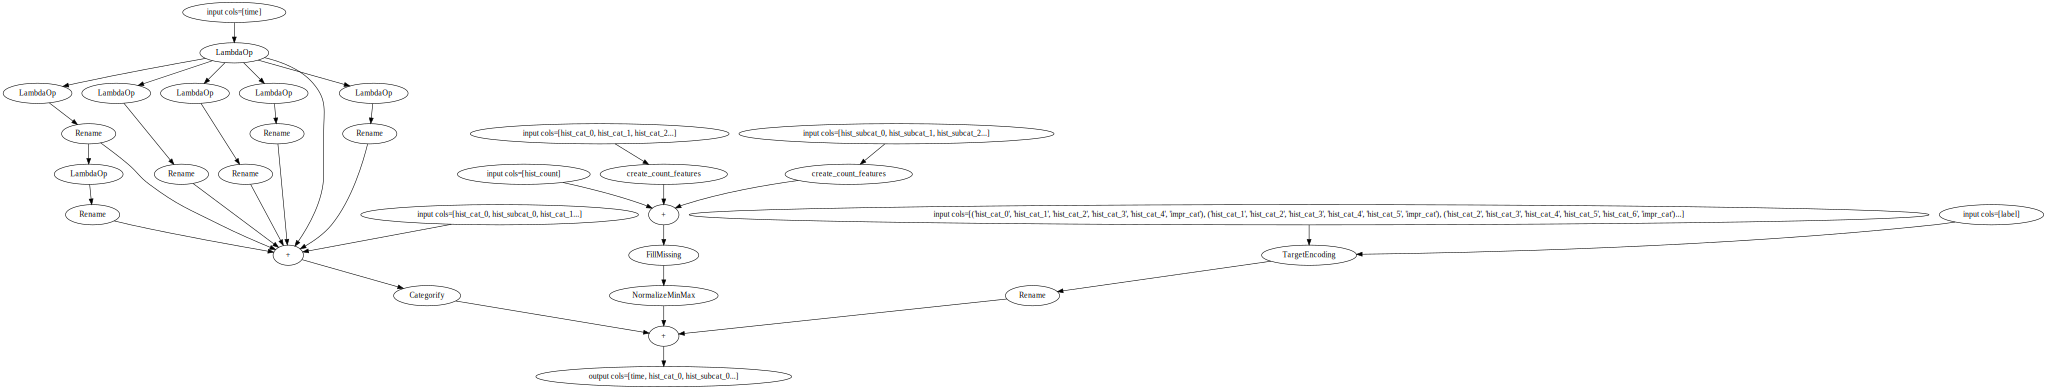

In [ ]:
output = cat_features + cont_features
output.graph

In [ ]:
proc = nvt.Workflow(cat_features + cont_features + labels[0])

In [ ]:
data_train = nvt.Dataset(os.path.join(data_input_path, "train.parquet"), engine="parquet",part_size="256MB")
data_valid = nvt.Dataset(os.path.join(data_input_path, "valid.parquet"), engine="parquet",part_size="256MB")

In [ ]:
dict_dtypes={}

for col in cat_features.columns:
    dict_dtypes[col] = np.int64

for col in cont_features.columns:
    dict_dtypes[col] = np.float32

for col in labels:
    dict_dtypes[col] = np.float32

In [ ]:
%%time
proc.fit(data_train)

CPU times: user 5min 38s, sys: 1min 36s, total: 7min 14s
Wall time: 7min 6s


In [ ]:
%%time

# For training set
proc.transform(data_train).to_parquet(output_path=output_train_path,
                                shuffle=nvt.io.Shuffle.PER_PARTITION,
                                dtypes=dict_dtypes,
                                out_files_per_proc=10,
                                cats = cat_features.columns,
                                conts = cont_features.columns,
                                labels = labels)

CPU times: user 57min 59s, sys: 12min 37s, total: 1h 10min 36s
Wall time: 1h 10min 1s


In [ ]:
%%time

# For validation set
proc.transform(data_valid).to_parquet(output_path=output_valid_path,
                                shuffle=nvt.io.Shuffle.PER_PARTITION,
                                dtypes=dict_dtypes,
                                out_files_per_proc=10,
                                cats = cat_features.columns,
                                conts = cont_features.columns,
                                labels = labels)
rmm.reinitialize(managed_memory=False)

CPU times: user 9min 53s, sys: 2min 8s, total: 12min 2s
Wall time: 11min 56s


In [ ]:
with open(os.path.join(output_train_path, '_metadata.json'),'r') as f:
    metadata = json.load(f)

metadata

{'file_stats': [{'file_name': '0.6b641595fcc742e3aa2758ccf3b12205.parquet',
   'num_rows': 7715947},
  {'file_name': '1.88063cff803b42509f06f272d74291d0.parquet',
   'num_rows': 7720030},
  {'file_name': '2.40ecd7d27df24705b0627b504ebc8616.parquet',
   'num_rows': 7715550},
  {'file_name': '3.c0c7e9a00f484e8193ea3c0f25f08965.parquet',
   'num_rows': 7714724},
  {'file_name': '4.4ea79a5b40b64ff681fce570749e6041.parquet',
   'num_rows': 7720890},
  {'file_name': '5.de5a10a5b2a54778bc733eac289cf592.parquet',
   'num_rows': 7715209},
  {'file_name': '6.85b83a311c584778a40987115a3c80c5.parquet',
   'num_rows': 7718409},
  {'file_name': '7.3eaae381ad9e497ab615fd9f927702ab.parquet',
   'num_rows': 7721110},
  {'file_name': '8.b2dabad9e730424d8c21f13591dc99b8.parquet',
   'num_rows': 7715087},
  {'file_name': '9.2b1125b0e9be4b6f9c6d387d688df406.parquet',
   'num_rows': 7718471}],
 'cats': [{'col_name': 'time', 'index': 0},
  {'col_name': 'hist_cat_0', 'index': 1},
  {'col_name': 'hist_subcat_0

In [ ]:
from nvtabular.ops import get_embedding_sizes
embeddings_count_encode =  get_embedding_sizes(proc)
embeddings_count_encode

{'hist_cat_0': (18, 16),
 'hist_cat_1': (18, 16),
 'hist_cat_2': (19, 16),
 'hist_cat_3': (18, 16),
 'hist_cat_4': (18, 16),
 'hist_cat_5': (18, 16),
 'hist_cat_6': (18, 16),
 'hist_cat_7': (18, 16),
 'hist_cat_8': (17, 16),
 'hist_cat_9': (17, 16),
 'hist_subcat_0': (235, 34),
 'hist_subcat_1': (239, 34),
 'hist_subcat_2': (236, 34),
 'hist_subcat_3': (235, 34),
 'hist_subcat_4': (229, 34),
 'hist_subcat_5': (224, 33),
 'hist_subcat_6': (225, 33),
 'hist_subcat_7': (219, 33),
 'hist_subcat_8': (213, 32),
 'hist_subcat_9': (199, 31),
 'impr_cat': (26708, 482),
 'impr_subcat': (26708, 482),
 'impression_id': (2232749, 512),
 'time': (90397, 512),
 'time_day': (7, 16),
 'time_day_week': (3, 16),
 'time_hour': (16, 16),
 'time_minute': (61, 16),
 'time_second': (61, 16),
 'time_wd': (6, 16),
 'uid': (711223, 512)}

In [ ]:
# Reformatting the above output for ease of copy paste in HugeCTRs config.json

embedding_size_str_count_encode = [embeddings_count_encode[x][0] for x in cat_features.columns]
embedding_size_str_count_encode

[90397,
 18,
 235,
 18,
 239,
 19,
 236,
 18,
 235,
 18,
 229,
 18,
 224,
 18,
 225,
 18,
 219,
 17,
 213,
 17,
 199,
 26708,
 26708,
 2232749,
 711223,
 16,
 61,
 61,
 6,
 7,
 3]

Now that we have 2 versions of our dataset ready, one with time based features and other with count + target encoded features, we can start training a few DNNs using HugeCTR.

### Training DLRM

Python low level train API requires a train config.json with the arguments and definitions of various training parameters like - optimizer, iterations, neural architecture and dataset.<br>
As a first step, we will develop this config file for our feature engineered dataset and DLRM model.

In [ ]:
# Paths to save the config and the weights

config_file_path = os.path.join(config_output_path,'dlrm_fp32_simple-time_1gpu.json')
weights_output_path = os.path.join(weights_path,'dlrm_fp32_simple-time_1gpu/')

# Creating Directory inside weights folder
if os.path.isdir(weights_output_path):
    shutil.rmtree(weights_output_path)
os.mkdir(weights_output_path)

first, we'll train on time based feature version of data

In [ ]:
# Path to the simple time based feature processed dataset
output_train_path = os.path.join(BASE_DIR, "processed_nvt/train")
output_valid_path = os.path.join(BASE_DIR, "processed_nvt/valid")

# Model related parameter
embedding_vec_size = 4

In [ ]:
# Model architecture and training configuration

optimizer = {
        "type": "Adam",
        "update_type": "Local",
        "adam_hparam": {
            "learning_rate": 0.001,
            "beta1": 0.9,
            "beta2": 0.999,
            "epsilon": 1e-07,
            "warmup_steps": 10000,
            "decay_start": 20000,
            "decay_steps": 200000,
            "decay_power": 1,
            "end_lr": 0.000001
        }
    }

layers = [
        {
            "name": "data",
            "type": "Data",
            "format": "Parquet",
            "slot_size_array": embedding_size_str_simple_time,
            "source": output_train_path+"/_file_list.txt",
            "eval_source": output_valid_path+"/_file_list.txt",
            "check": "None",
            "label": {
                "top": "label",
                "label_dim": 1
            },
            "dense": {
                "top": "dense",
                "dense_dim": 1
            },
            "sparse": [
                {
                    "top": "data1",
                    "type": "LocalizedSlot",
                    "max_feature_num_per_sample": len(embeddings_simple_time),
                    "max_nnz": 1,
                    "slot_num": len(embeddings_simple_time)
                }
            ]
        },
        {
            "name": "sparse_embedding1",
            "type": "LocalizedSlotSparseEmbeddingHash",
            "bottom": "data1",
            "top": "sparse_embedding1",
            "sparse_embedding_hparam": {
                "slot_size_array": embedding_size_str_simple_time,
                "embedding_vec_size": embedding_vec_size,
                "combiner": 0
            }
        },
        {
            "name": "fc1",
            "type": "InnerProduct",
            "bottom": "dense",
            "top": "fc1",
            "fc_param": {
                "num_output": 512
            }
        },
        {
            "name": "relu1",
            "type": "ReLU",
            "bottom": "fc1",
            "top": "relu1"
        },
        {
            "name": "fc2",
            "type": "InnerProduct",
            "bottom": "relu1",
            "top": "fc2",
            "fc_param": {
                "num_output": 256
            }
        },
        {
            "name": "relu2",
            "type": "ReLU",
            "bottom": "fc2",
            "top": "relu2"
        },
        {
            "name": "fc3",
            "type": "InnerProduct",
            "bottom": "relu2",
            "top": "fc3",
            "fc_param": {
                "num_output": embedding_vec_size
            }
        },
        {
            "name": "relu3",
            "type": "ReLU",
            "bottom": "fc3",
            "top": "relu3"
        },
        {
            "name": "interaction1",
            "type": "Interaction",
            "bottom": [
                "relu3",
                "sparse_embedding1"
            ],
            "top": "interaction1"
        },
        {
            "name": "fc4",
            "type": "InnerProduct",
            "bottom": "interaction1",
            "top": "fc4",
            "fc_param": {
                "num_output": 1024
            }
        },
        {
            "name": "relu4",
            "type": "ReLU",
            "bottom": "fc4",
            "top": "relu4"
        },
        {
            "name": "fc5",
            "type": "InnerProduct",
            "bottom": "relu4",
            "top": "fc5",
            "fc_param": {
                "num_output": 1024
            }
        },
        {
            "name": "relu5",
            "type": "ReLU",
            "bottom": "fc5",
            "top": "relu5"
        },
        {
            "name": "fc6",
            "type": "InnerProduct",
            "bottom": "relu5",
            "top": "fc6",
            "fc_param": {
                "num_output": 512
            }
        },
        {
            "name": "relu6",
            "type": "ReLU",
            "bottom": "fc6",
            "top": "relu6"
        },
        {
            "name": "fc7",
            "type": "InnerProduct",
            "bottom": "relu6",
            "top": "fc7",
            "fc_param": {
                "num_output": 256
            }
        },
        {
            "name": "relu7",
            "type": "ReLU",
            "bottom": "fc7",
            "top": "relu7"
        },
        {
            "name": "fc8",
            "type": "InnerProduct",
            "bottom": "relu7",
            "top": "fc8",
            "fc_param": {
                "num_output": 1
            }
        },
        {
            "name": "loss",
            "type": "BinaryCrossEntropyLoss",
            "bottom": [
                "fc8",
                "label"
            ],
            "top": "loss"
        }
    ]


In [ ]:
config = {
    "optimizer": optimizer,
    "layers": layers
}

with open(config_file_path,'w') as f:
    json.dump(config,f,indent = 4)

Finally, we can start the training using the above config file.

In [ ]:
import os
from hugectr import Session, solver_parser_helper,get_learning_rate_scheduler
from mpi4py import MPI

# Solver related parameters
NUM_GPUS = [0]                                                     
json_file = config_file_path                                       
batchsize = 2048                                                   
batchsize_eval = 2048                                              
max_eval_batches = 3768                                            

# Training related parameters
num_iter = 30001                                                   
eval_trigger = 10000                                               
snapshot_trigger = 10000                                           

solver_config = solver_parser_helper(
                                    seed = 0,
                                    batchsize = batchsize,                   
                                    batchsize_eval = batchsize_eval,         
                                    max_eval_batches = max_eval_batches,     
                                    model_file = "",                         
                                    embedding_files = [],                    
                                    vvgpu = [NUM_GPUS],                      
                                    use_mixed_precision = False,             
                                    scaler = 1024,                           
                                    i64_input_key = True,                    
                                    use_algorithm_search = False,            
                                    use_cuda_graph = False,                  
                                    repeat_dataset = True                    
                                    )

lr_sch = get_learning_rate_scheduler(json_file)                    

sess = Session(solver_config, json_file)                           
sess.start_data_reading()                                          

for i in range(num_iter):                                          
    lr = lr_sch.get_next()                                         
    sess.set_learning_rate(lr)                                     
    sess.train()                                                   

    if (i%1000 == 0):
        loss = sess.get_current_loss()                             
        print("[HUGECTR][INFO] iter: {}; loss: {:.6f}; lr: {:.6f}".format(i, loss, lr))
    if (i%eval_trigger == 0 and i != 0):
        sess.check_overflow()                                      
        sess.copy_weights_for_evaluation()                         
        for _ in range(solver_config.max_eval_batches):
            sess.eval()                                            
        metrics = sess.get_eval_metrics()                          
        print("[HUGECTR][INFO] iter: {}, {}".format(i, metrics))
    if (i%snapshot_trigger == 0 and i != 0):
        sess.download_params_to_files(weights_output_path , i)     

[HUGECTR][INFO] iter: 0; loss: 0.482908; lr: 0.000000[14d03h56m03s][HUGECTR][INFO]: Global seed is 3431791815

[14d03h56m04s][HUGECTR][INFO]: Peer-to-peer access cannot be fully enabled.
Device 0: NVIDIA A100-SXM4-40GB
[14d03h56m04s][HUGECTR][INFO]: cache_eval_data is not specified using default: 0
[14d03h56m04s][HUGECTR][INFO]: num_workers is not specified using default: 1
[14d03h56m04s][HUGECTR][INFO]: num of DataReader workers: 1
[14d03h56m04s][HUGECTR][INFO]: num_internal_buffers 1
[14d03h56m04s][HUGECTR][INFO]: num_internal_buffers 1
[14d03h56m04s][HUGECTR][INFO]: Vocabulary size: 3090372
[14d03h56m04s][HUGECTR][INFO]: max_vocabulary_size_per_gpu_=3090372
[14d03h56m04s][HUGECTR][INFO]: All2All Warmup Start
[14d03h56m04s][HUGECTR][INFO]: All2All Warmup End
[14d03h56m04s][HUGECTR][INFO]: gpu0 start to init embedding of slot0 , slot_size=16, key_offset=0, value_index_offset=0
[14d03h56m04s][HUGECTR][INFO]: gpu0 start to init embedding of slot1 , slot_size=18, key_offset=16, value_ind

Following the same methodology as done above, we will modify the DLRM config file for count + target encoded feature dataset

In [ ]:
# Define paths to save the config and the weights

config_file_path = os.path.join(config_output_path, 'dlrm_fp32_count-target-encode_1gpu.json')
weights_output_path = os.path.join(weights_path,'dlrm_fp32_count-target-encode_1gpu/')

# Creating Directory inside weights folder
if os.path.isdir(weights_output_path):
    shutil.rmtree(weights_output_path)
os.mkdir(weights_output_path)

In [ ]:
# Path to the simple time based feature processed dataset
output_train_path = os.path.join(BASE_DIR, "processed_ce-te/train")
output_valid_path = os.path.join(BASE_DIR, "processed_ce-te/valid")

# Model related parameter
embedding_vec_size = 4

In [ ]:
optimizer = {
        "type": "Adam",
        "update_type": "Local",
        "adam_hparam": {
            "learning_rate": 0.001,
            "beta1": 0.9,
            "beta2": 0.999,
            "epsilon": 1e-07,
            "warmup_steps": 10000,
            "decay_start": 20000,
            "decay_steps": 200000,
            "decay_power": 1,
            "end_lr": 1e-06
        }
    }

layers = [
        {
            "name": "data",
            "type": "Data",
            "format": "Parquet",
            "slot_size_array": embedding_size_str_count_encode,
            "source": output_train_path+"/_file_list.txt",
            "eval_source": output_valid_path+"/_file_list.txt",
            "check": "None",
            "label": {
                "top": "label",
                "label_dim": 1
            },
            "dense": {
                "top": "dense",
                "dense_dim": 9
            },
            "sparse": [
                {
                    "top": "data1",
                    "type": "LocalizedSlot",
                    "max_feature_num_per_sample": len(embeddings_count_encode),
                    "max_nnz": 1,
                    "slot_num": len(embeddings_count_encode)
                }
            ]
        },
        {
            "name": "sparse_embedding1",
            "type": "LocalizedSlotSparseEmbeddingHash",
            "bottom": "data1",
            "top": "sparse_embedding1",
            "sparse_embedding_hparam": {
                "slot_size_array": embedding_size_str_count_encode,
                "embedding_vec_size": embedding_vec_size,
                "combiner": 0
            }
        },
        {
            "name": "fc1",
            "type": "InnerProduct",
            "bottom": "dense",
            "top": "fc1",
            "fc_param": {
                "num_output": 512
            }
        },
        {
            "name": "relu1",
            "type": "ReLU",
            "bottom": "fc1",
            "top": "relu1"
        },
        {
            "name": "fc2",
            "type": "InnerProduct",
            "bottom": "relu1",
            "top": "fc2",
            "fc_param": {
                "num_output": 256
            }
        },
        {
            "name": "relu2",
            "type": "ReLU",
            "bottom": "fc2",
            "top": "relu2"
        },
        {
            "name": "fc3",
            "type": "InnerProduct",
            "bottom": "relu2",
            "top": "fc3",
            "fc_param": {
                "num_output": embedding_vec_size
            }
        },
        {
            "name": "relu3",
            "type": "ReLU",
            "bottom": "fc3",
            "top": "relu3"
        },
        {
            "name": "interaction1",
            "type": "Interaction",
            "bottom": [
                "relu3",
                "sparse_embedding1"
            ],
            "top": "interaction1"
        },
        {
            "name": "fc4",
            "type": "InnerProduct",
            "bottom": "interaction1",
            "top": "fc4",
            "fc_param": {
                "num_output": 1024
            }
        },
        {
            "name": "relu4",
            "type": "ReLU",
            "bottom": "fc4",
            "top": "relu4"
        },
        {
            "name": "fc5",
            "type": "InnerProduct",
            "bottom": "relu4",
            "top": "fc5",
            "fc_param": {
                "num_output": 1024
            }
        },
        {
            "name": "relu5",
            "type": "ReLU",
            "bottom": "fc5",
            "top": "relu5"
        },
        {
            "name": "fc6",
            "type": "InnerProduct",
            "bottom": "relu5",
            "top": "fc6",
            "fc_param": {
                "num_output": 512
            }
        },
        {
            "name": "relu6",
            "type": "ReLU",
            "bottom": "fc6",
            "top": "relu6"
        },
        {
            "name": "fc7",
            "type": "InnerProduct",
            "bottom": "relu6",
            "top": "fc7",
            "fc_param": {
                "num_output": 256
            }
        },
        {
            "name": "relu7",
            "type": "ReLU",
            "bottom": "fc7",
            "top": "relu7"
        },
        {
            "name": "fc8",
            "type": "InnerProduct",
            "bottom": "relu7",
            "top": "fc8",
            "fc_param": {
                "num_output": 1
            }
        },
        {
            "name": "loss",
            "type": "BinaryCrossEntropyLoss",
            "bottom": [
                "fc8",
                "label"
            ],
            "top": "loss"
        }
    ]


In [ ]:
config = {
    "optimizer": optimizer,
    "layers": layers
}
with open(config_file_path,'w') as f:
    json.dump(config,f,indent = 4)

In [ ]:
# Solver related parameters
NUM_GPUS = [0]                                               # GPUs used for training
json_file = config_file_path                                       # Path to the json config file
batchsize = 2048                                                   # Batch size used for training
batchsize_eval = 2048                                              # Batch size used during evaluation
max_eval_batches = 3768                                            # Iterations required to go through the complete validation set with the set batchsize_eval

# Training related parameters
num_iter = 30001                                                   # Iterations to train the model for
eval_trigger = 10000                                               # Start evaluation after these iterations
snapshot_trigger = 10000                                           # Save model checkpoints after these iterations

solver_config = solver_parser_helper(
                                    seed = 0,
                                    batchsize = batchsize,                       # Minibatch size for training
                                    batchsize_eval = batchsize_eval,         # Minibatch size for eval 
                                    max_eval_batches = max_eval_batches,     # Max no. of eval batches on which eval will be done
                                    model_file = "",                         # Load any pretrained model , if training from scratch, leave empty
                                    embedding_files = [],                    # Path to trained embedding table, if training from scratch then leave empty
                                    vvgpu = [NUM_GPUS],                      # GPU Indices to be used ofr training
                                    use_mixed_precision = False,             # Flag to indicate use of Mixed precision training 
                                    scaler = 1024,                           # To be set when MixedPrecisiontraining is ON
                                    i64_input_key = True,                    # As we are using Parquet from NVTabular, I64 should be true 
                                    use_algorithm_search = False,            # Enable algo search within the fully connected-layers
                                    use_cuda_graph = False,                  # Enable cuda graph for forward and back proppogation
                                    repeat_dataset = True                    # Repeat the dataset for training, True for Non Epoch Based Training
                                    )

lr_sch = get_learning_rate_scheduler(json_file)                    # Get learning rate statistics from optimizers     

sess = Session(solver_config, json_file)                           # Initialise a Session Object
sess.start_data_reading()                                          # Start Data Reading

for i in range(num_iter):                                          # Start training loop
    lr = lr_sch.get_next()                                         # Update learning rate parameters                                   
    sess.set_learning_rate(lr)                                     # Pass the updated learning rate to the session
    sess.train()                                                   # Train on 1 iteration on 1 Minibatch

    if (i%1000 == 0):
        loss = sess.get_current_loss()                             # Returns the loss value for the current iteration.
        print("[HUGECTR][INFO] iter: {}; loss: {:.6f}; lr: {:.6f}".format(i, loss, lr))
    if (i%eval_trigger == 0 and i != 0):
        sess.check_overflow()                                      # Checks whether any embedding has encountered overflow
        sess.copy_weights_for_evaluation()                         # Copies the weights of the dense network from training layers to evaluation layers.
        for _ in range(solver_config.max_eval_batches):
            sess.eval()                                            # Calculates the evaluation metrics based on one minibatch of evaluation data
        metrics = sess.get_eval_metrics()                          # Returns the average evaluation metrics of several minibatches of evaluation data.
        print("[HUGECTR][INFO] iter: {}, {}".format(i, metrics))
    if (i%snapshot_trigger == 0 and i != 0):
        sess.download_params_to_files(weights_output_path , i)     # Saving model

[14d03h59m04s][HUGECTR][INFO]: Global seed is 619798231
[14d03h59m04s][HUGECTR][INFO]: Peer-to-peer access cannot be fully enabled.
Device 0: NVIDIA A100-SXM4-40GB
[14d03h59m04s][HUGECTR][INFO]: cache_eval_data is not specified using default: 0
[14d03h59m04s][HUGECTR][INFO]: num_workers is not specified using default: 1
[14d03h59m04s][HUGECTR][INFO]: num of DataReader workers: 1
[14d03h59m04s][HUGECTR][INFO]: num_internal_buffers 1
[14d03h59m04s][HUGECTR][INFO]: num_internal_buffers 1
[14d03h59m04s][HUGECTR][INFO]: Vocabulary size: 3090372
[14d03h59m04s][HUGECTR][INFO]: max_vocabulary_size_per_gpu_=3090372
[14d03h59m04s][HUGECTR][INFO]: All2All Warmup Start
[14d03h59m04s][HUGECTR][INFO]: All2All Warmup End
[14d03h59m04s][HUGECTR][INFO]: gpu0 start to init embedding of slot0 , slot_size=90397, key_offset=0, value_index_offset=0
[14d03h59m04s][HUGECTR][INFO]: gpu0 start to init embedding of slot1 , slot_size=18, key_offset=90397, value_index_offset=90397
[14d03h59m04s][HUGECTR][INFO]: gp